In [2]:
import timm
from fastai.vision.all import *

dk_dir = Path("dk_bugs_preproc")
fin_dir = Path("finland_bugs")
ept_dir = Path("ept_bugs_preproc")

model_dir = Path("models")

In [3]:
print(len(get_image_files(dk_dir)))
print(len(get_image_files(fin_dir)))
print(len(get_image_files(ept_dir)))

2526
15074
4784


In [4]:
#define dataloaders
fin_dl = ImageDataLoaders.from_folder(path=fin_dir, 
                                      valid_pct=0.2, 
                                      bs=64, 
                                      batch_tfms=aug_transforms(mult=1, size=224, flip_vert=True))
ept_dl = ImageDataLoaders.from_folder(path=ept_dir, 
                                      valid_pct=0.2, 
                                      bs=64, 
                                      batch_tfms=aug_transforms(mult=1, size=224, flip_vert=True))

In [5]:
targets = [parent_label(i) for i in get_image_files(dk_dir)]

def get_dls(bs, size):
    dl = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items = get_image_files,
                  splitter = TrainTestSplitter(stratify=targets),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=2, size=size, min_scale=0.75, flip_vert=True),
                  get_y = parent_label).dataloaders(dk_dir, batch_size = bs)
    return(dl)

In [6]:
dk_dl = get_dls(64, 224)

In [12]:
dk_n = len(dk_dl.vocab)
fin_n = len(fin_dl.vocab)
ept_n = len(ept_dl.vocab)

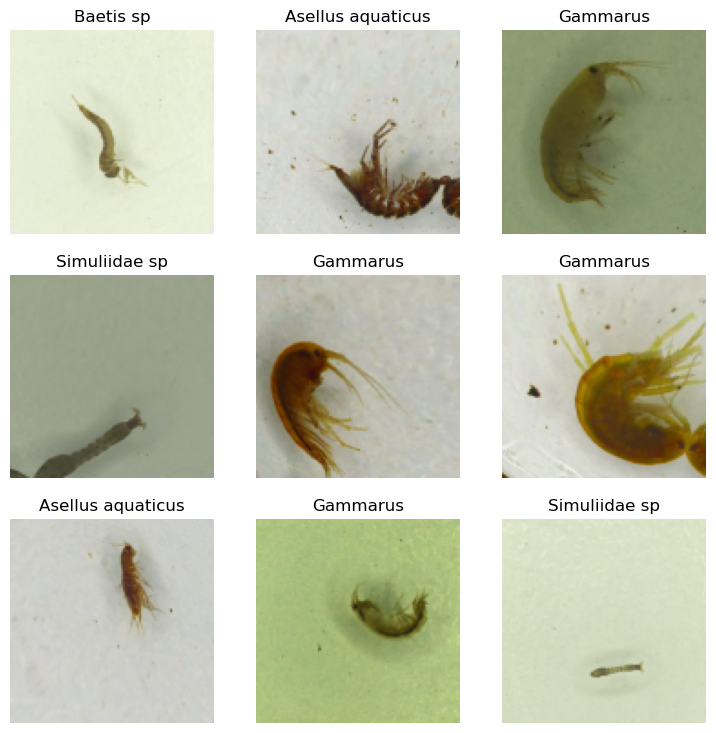

In [12]:
dk_dl.show_batch()

In [8]:
#train learner using ept dataset
learn = vision_learner(ept_dl, 
                       "efficientnet_b0",
                       pretrained=True,
                       cbs=[MixUp()],
                       loss_func=CrossEntropyLossFlat(),
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [9]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.267528,1.116651,0.666318,0.911088,00:08
1,2.244761,0.688290,0.794979,0.968619,00:07
2,1.792304,0.501025,0.838912,0.983264,00:07
3,1.550314,0.458727,0.872385,0.988494,00:07
4,1.356755,0.383637,0.895397,0.987448,00:07
5,1.257570,0.322661,0.906904,0.990586,00:07
6,1.172210,0.283057,0.924686,0.993724,00:07
7,1.089007,0.256131,0.925732,0.994770,00:07
8,1.058144,0.229368,0.942469,0.995816,00:07
9,1.018177,0.194529,0.953975,0.995816,00:07


Linear(in_features=512, out_features=28, bias=False)

In [17]:
#prepare model for training with fin data
learn.model[-1][-1]=nn.Linear(in_features=512, out_features=fin_n, bias=False)
learn.dls = fin_dl

In [18]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.484459,2.505657,0.457200,0.737558,00:23
1,2.487287,1.440144,0.657266,0.896151,00:23
2,2.023681,1.010230,0.747512,0.937956,00:22
3,1.748488,0.742546,0.809224,0.959522,00:23
4,1.647708,0.619417,0.836098,0.975116,00:23
5,1.539377,0.531038,0.860319,0.979098,00:23
6,1.469559,0.474225,0.869940,0.982747,00:23
7,1.435834,0.454860,0.875581,0.983079,00:23
8,1.402208,0.402260,0.888852,0.987060,00:23
9,1.356127,0.385842,0.893497,0.988056,00:23


In [19]:
#prepare model for training with dk data
learn.model[-1][-1]=nn.Linear(in_features=512, out_features=dk_n, bias=False)
learn.dls = dk_dl
learn.loss_func = LabelSmoothingCrossEntropy()


In [20]:
learn.fit_one_cycle(20, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.649380,2.931625,0.229249,0.590909,00:06
1,3.312195,1.907019,0.671937,0.806324,00:05
2,2.832155,1.342921,0.806324,0.909091,00:05
3,2.429857,1.130897,0.857708,0.946640,00:05
4,2.146523,1.035685,0.879447,0.960474,00:06
5,1.960050,0.979871,0.899209,0.974308,00:05
6,1.832162,0.934727,0.913043,0.978261,00:06
7,1.730626,0.910881,0.915020,0.990119,00:06
8,1.656048,0.890974,0.924901,0.992095,00:06
9,1.592419,0.868339,0.924901,0.994071,00:06


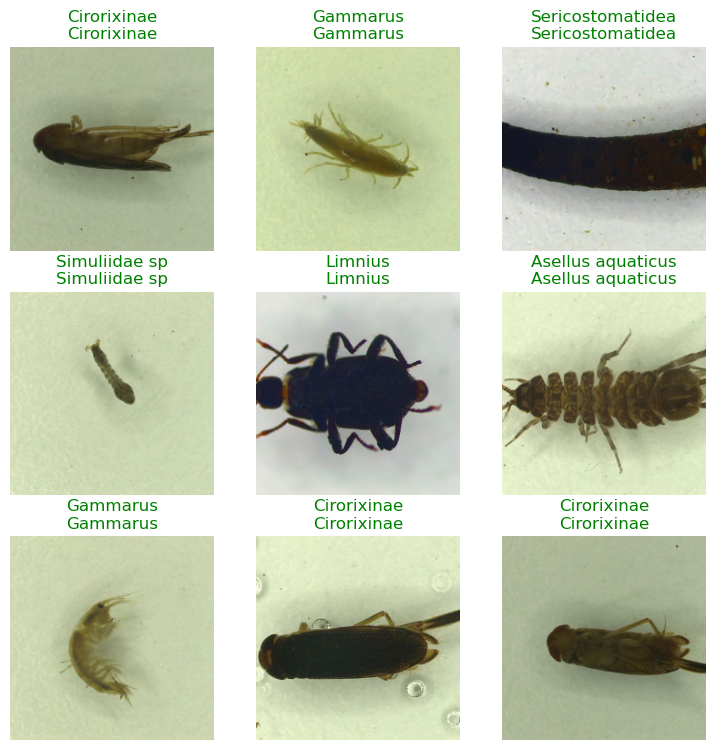

In [24]:
learn.show_results()

In [28]:
#save model
learn.path = model_dir
learn.export("effnet_b0.export")

In [29]:
#load model
learn = load_learner(model_dir/"effnet_b0.export")

In [31]:
vocab = learn.dls.vocab
#np.save(model_dir/"dk_vocab.npy", vocab)

In [37]:
#write to text file
with open(model_dir/"dk_vocab.txt", 'w') as f:
    for i in vocab:
        # write each item on a new line
        f.write('\n'.join(vocab))

In [34]:
#TIMM MODELS ER UDEN IMAGE NORMALIZATION

#define normalization layer
#normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#assemble the final model
final_model = nn.Sequential(torch_model, softmax_layer)

In [35]:
# generate model input
dummy_input = torch.randn(1, 3, 224, 224, requires_grad=True)

onnx_model_path = model_dir/"effnet_b0.onnx"


In [36]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

In [ ]:
#below is leftovers using manual preprocessing and reproducing fastai predictions

In [6]:
tmp="dk_bugs_preproc/Asellus aquaticus/Asellus aquaticus001.jpg"

In [7]:
pred, pred_idx, probs = learn.predict(tmp)
print(pred)
print(pred_idx)
print(probs)

Gammarus
TensorBase(7)
TensorBase([0.3728, 0.0188, 0.0018, 0.0025, 0.0108, 0.0030, 0.0013, 0.5002,
            0.0046, 0.0034, 0.0060, 0.0018, 0.0062, 0.0020, 0.0064, 0.0052,
            0.0067, 0.0048, 0.0013, 0.0032, 0.0054, 0.0109, 0.0020, 0.0021,
            0.0084, 0.0038, 0.0048])


In [38]:
def center_crop(img):
    
    height, width, _ = img.shape
    min_dim = min(height, width)
    x_min = width//2 - min_dim//2
    x_max = width//2 + min_dim//2
    y_min = height//2 - min_dim//2
    y_max = height//2 + min_dim//2

    img_crop = img[y_min:y_max, x_min:x_max]
    
    return(img_crop)

In [39]:
#def torch_predict(path):
img = cv2.imread(tmp)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_crop = center_crop(img)
img_resize = cv2.resize(img_crop, (224, 224), interpolation = cv2.INTER_LINEAR)
#img_norm = (img_resize - imagenet_stats[0])/imagenet_stats[1]
img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0)/255

In [19]:
final_model.eval()

with torch.no_grad():
    logits = final_model(img_tensor)
    #preds = torch.nn.functional.softmax(logits, dim=1)
    pred_ind = torch.argmax(logits, dim=1)
    label = vocab[pred_ind]

In [21]:
from matplotlib import pyplot as plt

In [ ]:
plt.imshow(img_resize)

In [ ]:
plt.imshow(np.moveaxis(input_blob.squeeze(), 0, -1))